In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [9]:
!pip install kaggle

In [10]:
!pip install kagglehub
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", dataset_path)

# Count the number of files in the directory
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print("Number of files in the directory:", file_count)

Path to dataset files: C:\Users\Malika sahifa samira\.cache\kagglehub\datasets\ismailnasri20\driver-drowsiness-dataset-ddd\versions\1
Number of files in the directory: 41793


In [11]:
!pip install split-folders

In [12]:
for root, dirs, files in os.walk(dataset_path):
    print("Directory:", root)
    print("Contains directories:", dirs)
    print("Contains files:", files)

Directory: C:\Users\Malika sahifa samira\.cache\kagglehub\datasets\ismailnasri20\driver-drowsiness-dataset-ddd\versions\1
Contains directories: ['Driver Drowsiness Dataset (DDD)']
Contains files: []
Directory: C:\Users\Malika sahifa samira\.cache\kagglehub\datasets\ismailnasri20\driver-drowsiness-dataset-ddd\versions\1\Driver Drowsiness Dataset (DDD)
Contains directories: ['Drowsy', 'Non Drowsy']
Contains files: []
Directory: C:\Users\Malika sahifa samira\.cache\kagglehub\datasets\ismailnasri20\driver-drowsiness-dataset-ddd\versions\1\Driver Drowsiness Dataset (DDD)\Drowsy
Contains directories: []
Contains files: ['A0001.png', 'A0002.png', 'A0003.png', 'A0004.png', 'A0005.png', 'A0006.png', 'A0007.png', 'A0008.png', 'A0009.png', 'A0010.png', 'A0011.png', 'A0012.png', 'A0013.png', 'A0014.png', 'A0015.png', 'A0016.png', 'A0017.png', 'A0018.png', 'A0019.png', 'A0020.png', 'A0021.png', 'A0022.png', 'A0023.png', 'A0024.png', 'A0025.png', 'A0026.png', 'A0027.png', 'A0028.png', 'A0029.png', '

In [13]:
import splitfolders
import os

# Path to the subdirectory containing 'Drowsy' and 'Non Drowsy'
actual_dataset_path = os.path.join(
    dataset_path,
    "Driver Drowsiness Dataset (DDD)"
)

# Verify that the path contains subdirectories
print("Contents of the dataset directory:")
print(os.listdir(actual_dataset_path))

# Split the dataset
output_dir = 'splitted_dataset'
splitfolders.ratio(actual_dataset_path, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Contents of the dataset directory:
['Drowsy', 'Non Drowsy']


Copying files: 41793 files [01:08, 606.42 files/s]


In [14]:
train_dir = "splitted_dataset/train"
test_dir = "splitted_dataset/test"
val_dir = "splitted_dataset/val"

In [15]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import os

class FrameSequenceGenerator(Sequence):
    def __init__(self, directory, batch_size=16, seq_length=10, target_size=(224, 224), shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.target_size = target_size
        self.shuffle = shuffle
        self.classes = sorted(os.listdir(directory))  # Get class names
        self.class_indices = {cls: i for i, cls in enumerate(self.classes)}
        self.files = self._load_files()
        self.on_epoch_end()

    def _load_files(self):
        """Load all files and group them by sequence."""
        file_sequences = []
        for cls in self.classes:
            cls_path = os.path.join(self.directory, cls)
            files = sorted(os.listdir(cls_path))  # Ensure proper sequence order
            sequences = [files[i: i + self.seq_length] for i in range(len(files) - self.seq_length)]
            file_sequences.extend([(cls, seq) for seq in sequences])
        return file_sequences

    def __len__(self):
        """Number of batches per epoch."""
        return len(self.files) // self.batch_size

    def __getitem__(self, index):
        """Generate a batch of sequences."""
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []

        for cls, seq in batch_files:
            frames = []
            for file in seq:
                img_path = os.path.join(self.directory, cls, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, self.target_size) / 255.0  # Normalize
                frames.append(img)
            
            X.append(frames)
            y.append(self.class_indices[cls])

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            np.random.shuffle(self.files)

# Define sequence length for training
seq_length = 10  

# Update dataset pipeline
train_batches = FrameSequenceGenerator(train_dir, batch_size=16, seq_length=seq_length)
val_batches = FrameSequenceGenerator(val_dir, batch_size=16, seq_length=seq_length)
test_batches = FrameSequenceGenerator(test_dir, batch_size=16, seq_length=seq_length)


In [16]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({'Drowsy': 1, 'Non Drowsy': 1})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({'Drowsy': 1, 'Non Drowsy': 1})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({'Drowsy': 1, 'Non Drowsy': 1})


Pixels of the first image after Normalization: 

[[[[0.99215686 1.         0.88627451]
   [0.99215686 1.         0.87843137]
   [0.99215686 1.         0.86666667]
   ...
   [0.86666667 0.76862745 0.49803922]
   [0.86666667 0.76862745 0.49411765]
   [0.86666667 0.76862745 0.49411765]]

  [[0.99215686 1.         0.88627451]
   [0.99215686 1.         0.87843137]
   [0.99215686 1.         0.86666667]
   ...
   [0.86666667 0.76862745 0.49411765]
   [0.86666667 0.76862745 0.49411765]
   [0.86666667 0.76862745 0.49411765]]

  [[0.99215686 1.         0.88627451]
   [0.99215686 1.         0.87843137]
   [0.99215686 1.         0.8745098 ]
   ...
   [0.87058824 0.77254902 0.49803922]
   [0.87058824 0.77254902 0.49803922]
   [0.87058824 0.77254902 0.49803922]]

  ...

  [[0.76078431 0.6        0.40784314]
   [0.76078431 0.59215686 0.41568627]
   [0.73333333 0.55686275 0.39607843]
   ...
   [0.92156863 0.82352941 0.55686275]
   [0.92156863 0.82352941 0.55294118]
   [0.91764706 0.82352941 0.54509804

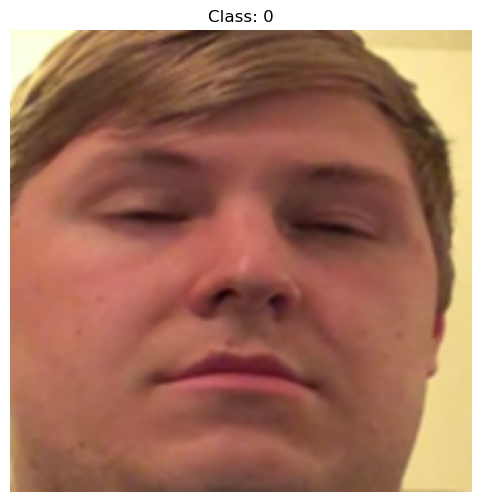

In [17]:
import matplotlib.pyplot as plt

# Retrieve a batch of images and labels from the training set
images, labels = train_batches.__getitem__(0)
single_frame = images[0][0]  # Selecting the first frame from the first sequence

# Print the pixel values of the first image after normalization
# Normalization should have scaled the pixel values to a range of [0, 1]
print(f"Pixels of the first image after Normalization: \n\n{images[0]}")

# Plot the first image to visually inspect the preprocessing
plt.figure(figsize=(6,6))  # Set the figure size for better visualization
plt.imshow(single_frame)  # Display the first image in the batch
plt.axis('off')  # Remove axis labels for a cleaner display
plt.title(f"Class: {labels[0]}")  # Show the class label (Drowsy or Non-Drowsy) on the plot
plt.show()

In [18]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 4 Channels 
image shape : (10, 224, 224, 3)


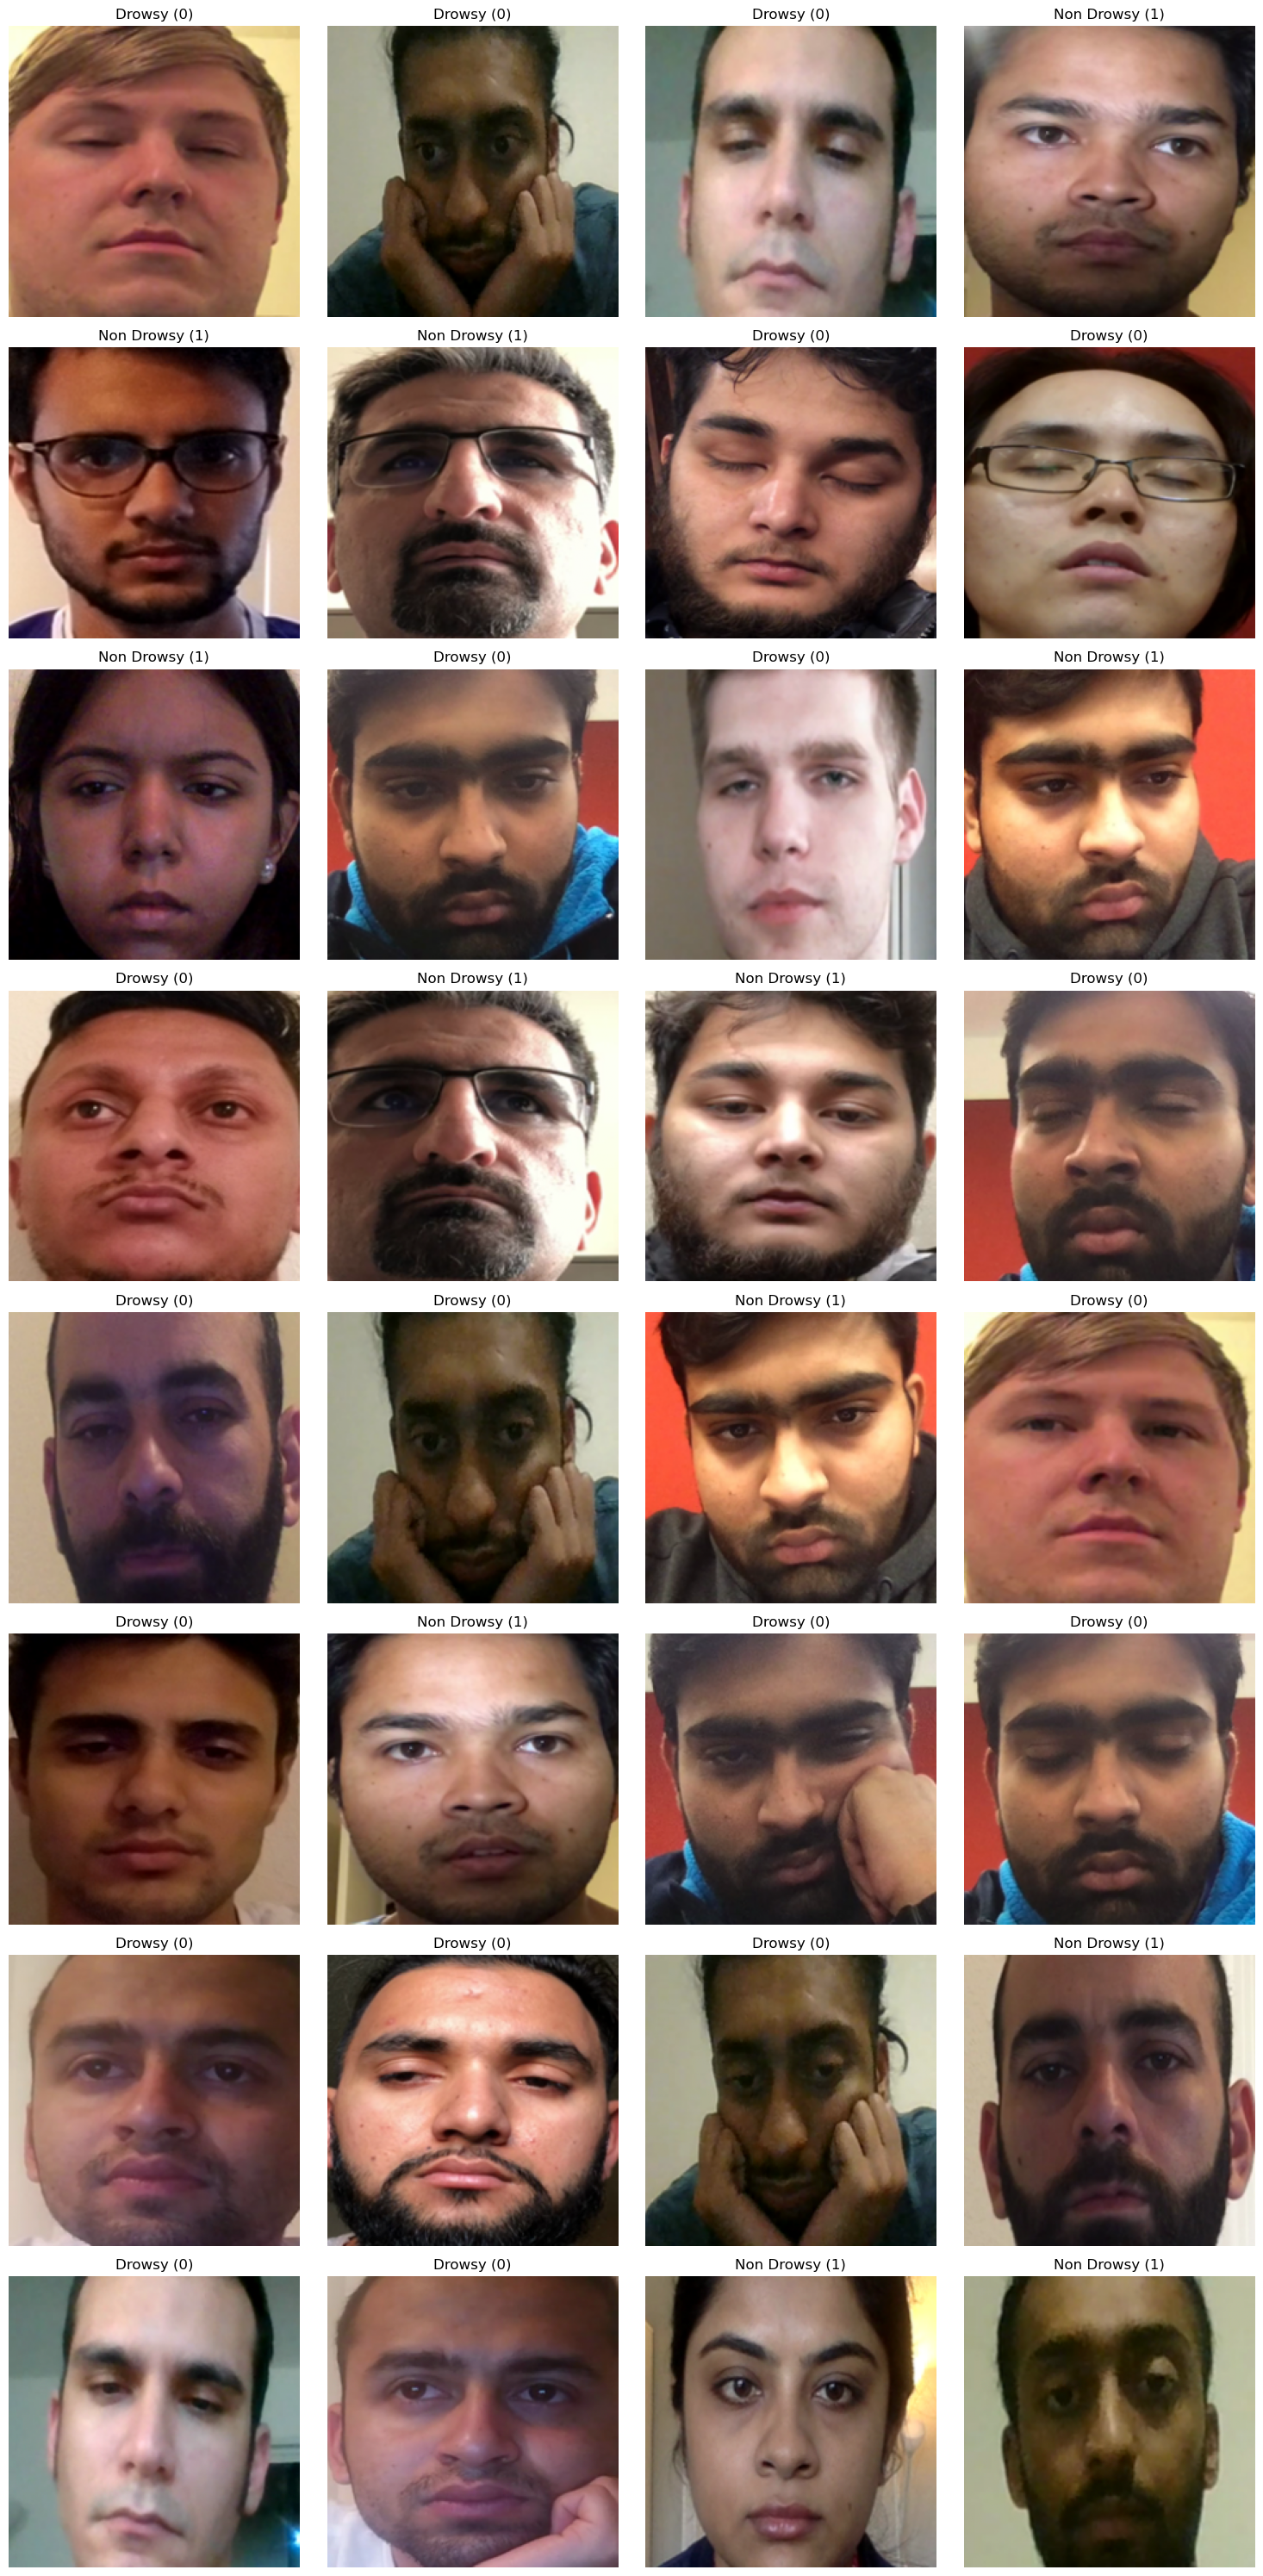

In [19]:
import matplotlib.pyplot as plt

# Create a grid of 8 rows and 4 columns for displaying images
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

# Get class indices to map labels to their corresponding class names
class_indices = train_batches.class_indices

# Loop through the 8 rows and 4 columns to display 32 images
for i in range(8):
    images, labels = train_batches.__getitem__(i)

    for j in range(4):
        ax = axes[i, j]

        # Select the first frame from each sequence
        single_frame = images[j][0]  # Pick first frame from sequence

        # Display the image
        ax.imshow(single_frame)
        # Hide the axes for better clarity
        ax.axis('off')

        # Get the label for the image and map it to the class name
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]

        # Set the title with the class name and label
        ax.set_title(f'{label_name} ({label})', fontsize=12)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
from tensorflow.keras.applications import MobileNetV3Small  # Or use MobileNetV3Large

# Define the image size
image_size = (224, 224)

# Initialize the MobileNetV3 model with the defined input shape
base_model = MobileNetV3Small(  # Change to MobileNetV3Large if needed
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

# Check the type of the base model
print(type(base_model))


<class 'keras.src.models.functional.Functional'>


In [21]:
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [22]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, GlobalAveragePooling2D, Input

# Define the sequence length (number of frames per input)
seq_length = 10  

# Define input shape for sequences (batch, seq_length, height, width, channels)
input_layer = Input(shape=(seq_length, 224, 224, 3))

# Load MobileNetV3 as CNN feature extractor
base_cnn = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers BEFORE wrapping in TimeDistributed
for layer in base_cnn.layers[:-20]:  
    layer.trainable = False  

# Apply MobileNetV3 to each frame using TimeDistributed
base_model = TimeDistributed(base_cnn)(input_layer)

# Apply GlobalAveragePooling2D on each frame
x = TimeDistributed(GlobalAveragePooling2D())(base_model)  # Shape: (batch, seq_length, features)

# LSTM for Temporal Analysis
x = LSTM(512, return_sequences=False)(x)  # Now LSTM correctly processes sequential data

# Fully Connected Layers
x = Dense(1024, activation='swish')(x)  
x = Dense(512, activation='swish')(x)  
predictions = Dense(2, activation='softmax')(x)  

# Define Model
model = Model(inputs=input_layer, outputs=predictions)

# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 7, 7, 576)  │       939,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 576)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │     2,230,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,220,530 (16.10 MB)

 Trainable params: 3,632,146 (13.86 MB)

 Non-trainable params: 588,384 (2.24 MB)

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import tensorflow as tf

# Define Learning Rate Callback
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()  # Correct way to access LR in TF 2.11+
        print(f"Epoch {epoch+1}: Learning rate is {lr}")

# Compile the model with an optimized learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Start with a moderate learning rate
    loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, PrintLR()]  # Use both EarlyStopping & LR Reduction
)


Epoch 1/5


Copying files: 11084 files [1:17:19,  2.39 files/s]


2088/2088 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9839 - loss: 0.0449Epoch 1: Learning rate is 9.999999747378752e-05
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 3770s 2s/step - accuracy: 0.9839 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 6.3339e-04 - learning_rate: 1.0000e-04
Epoch 2/5
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9911 - loss: 0.0251Epoch 2: Learning rate is 9.999999747378752e-05
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 3705s 2s/step - accuracy: 0.9911 - loss: 0.0251 - val_accuracy: 1.0000 - val_loss: 2.5747e-04 - learning_rate: 1.0000e-04
Epoch 3/5
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9949 - loss: 0.0167Epoch 3: Learning rate is 9.999999747378752e-05
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 3719s 2s/step - accuracy: 0.9949 - loss: 0.0167 - val_accuracy: 0.8229 - val_loss: 0.8917 - learning_rate: 1.0000e-04
Epoch 4/5
2088/2088 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9957 - loss: 0.0137
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376

In [1]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
model.save('drowsiness_detection_model.keras')  # New recommended format


In [ ]:
!jupyter nbconvert --to script "source code.ipynb"


[NbConvertApp] Converting notebook source code.ipynb to script
[NbConvertApp] Writing 11585 bytes to source code.py


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Get model predictions
y_pred_prob = model.predict(val_batches)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)   # Convert to class labels

# Efficiently extract true labels
y_true = []
for _, y in val_batches:
    y_true.append(y.numpy())  # Store each batch separately

y_true = np.concatenate(y_true, axis=0)  # Convert list of arrays to a single NumPy array

# Print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (Handles Multi-Class)
num_classes = len(np.unique(y_true))

if num_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])  # Only for positive class
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    # Multi-class case: Plot ROC curve for each class
    y_true_one_hot = to_categorical(y_true, num_classes)
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend()
    plt.show()


NameError: name 'model' is not defined